In [1]:
import numpy as np
import dynamo as dyn
import matplotlib.pyplot as plt
from dynamo.tools.utils import nearest_neighbors

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


C:\Users\serch\anaconda3\envs\dynamo\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
tau=5
simulator = dyn.sim.Neurogenesis(dyn.sim.neurogenesis_params, r_aug=20, tau=tau)

|-----> The model contains 12 genes and 12 species
|-----> Adjusting parameters based on `r_aug` and `tau`...
|-----> 10 initial conditions have been created by augmentation.


In [3]:
simulator.simulate([0, 50], n_cells=5000)
adata = simulator.generate_anndata()

|-----> Sampling 5000 from 1110522 simulated data points.
|-----> 5000 cell with 12 genes stored in AnnData.


C:\Users\serch\anaconda3\envs\dynamo\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata.obsm['X_raw'] = adata.layers['total']
adata.obsm['velocity_raw'] = adata.layers['velocity_T']

In [5]:
dyn.pp.pca_monocle(adata, pca_key='X_pca')

AnnData object with n_obs × n_vars = 5000 × 12
    obs: 'trajectory', 'time'
    var: 'a', 'K', 'n', 'gamma', 'use_for_pca'
    uns: 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_raw', 'velocity_raw', 'X_pca'
    layers: 'velocity_T', 'total'

In [6]:
adata.obsm['velocity_pca'] = adata.obsm['velocity_raw'] @ adata.uns['PCs']

[<AxesSubplot:title={'center':'time'}, xlabel='PC 0', ylabel='PC 1'>,
 <AxesSubplot:title={'center':'time'}, xlabel='PC 2', ylabel='PC 3'>,
 <AxesSubplot:title={'center':'time'}, xlabel='PC 4', ylabel='PC 5'>]

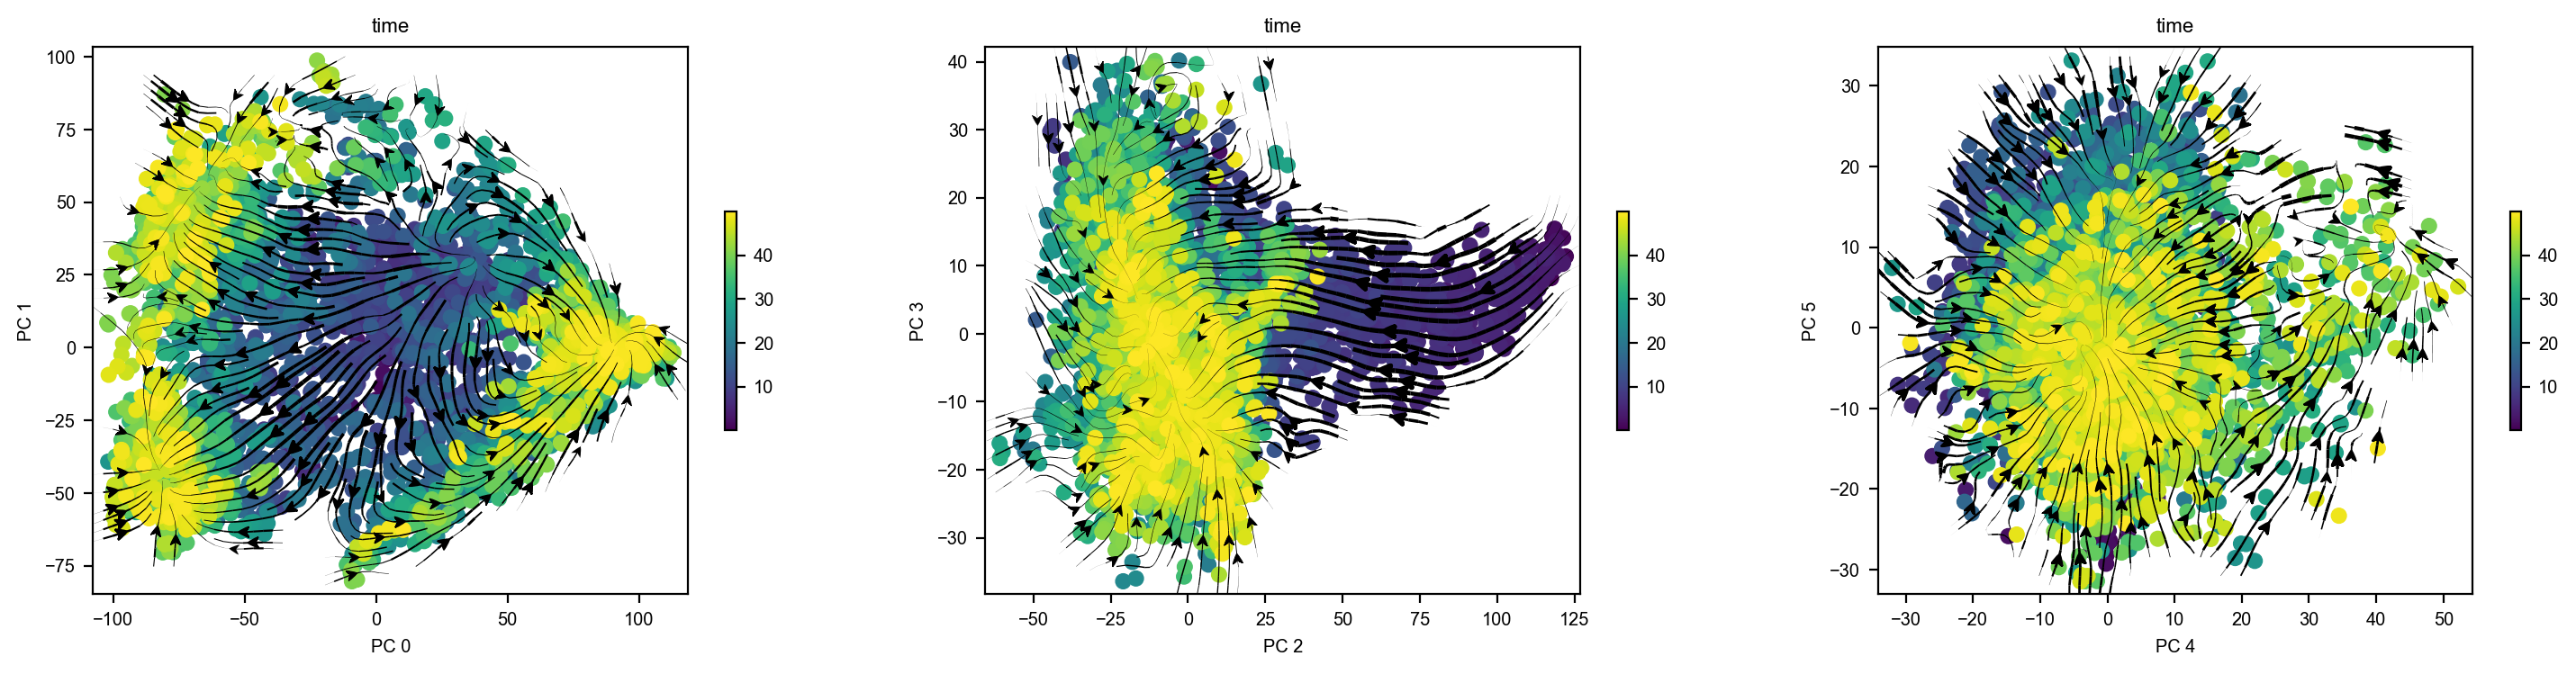

In [7]:
dyn.pl.multiplot(lambda x, y: 
                 [dyn.pl.zscatter(adata, basis='pca', color='time', dims=[x, y], cmap='viridis'), 
                  dyn.pl.zstreamline(adata, basis='pca', dims=[x, y]),
                  plt.axis('on'),
                  plt.xlabel(f'PC {x}'),
                  plt.ylabel(f'PC {y}'),
                 ],
                 [[0, 1], [2, 3], [4, 5]])

[<AxesSubplot:title={'center':'time'}, xlabel='Pax6', ylabel='Mash1'>,
 <AxesSubplot:title={'center':'time'}, xlabel='Zic1', ylabel='Brn2'>,
 <AxesSubplot:title={'center':'time'}, xlabel='Tuj1', ylabel='Hes5'>,
 <AxesSubplot:title={'center':'time'}, xlabel='Scl', ylabel='Olig2'>,
 <AxesSubplot:title={'center':'time'}, xlabel='Stat3', ylabel='A1dh1L'>,
 <AxesSubplot:title={'center':'time'}, xlabel='Myt1L', ylabel='Sox8'>]

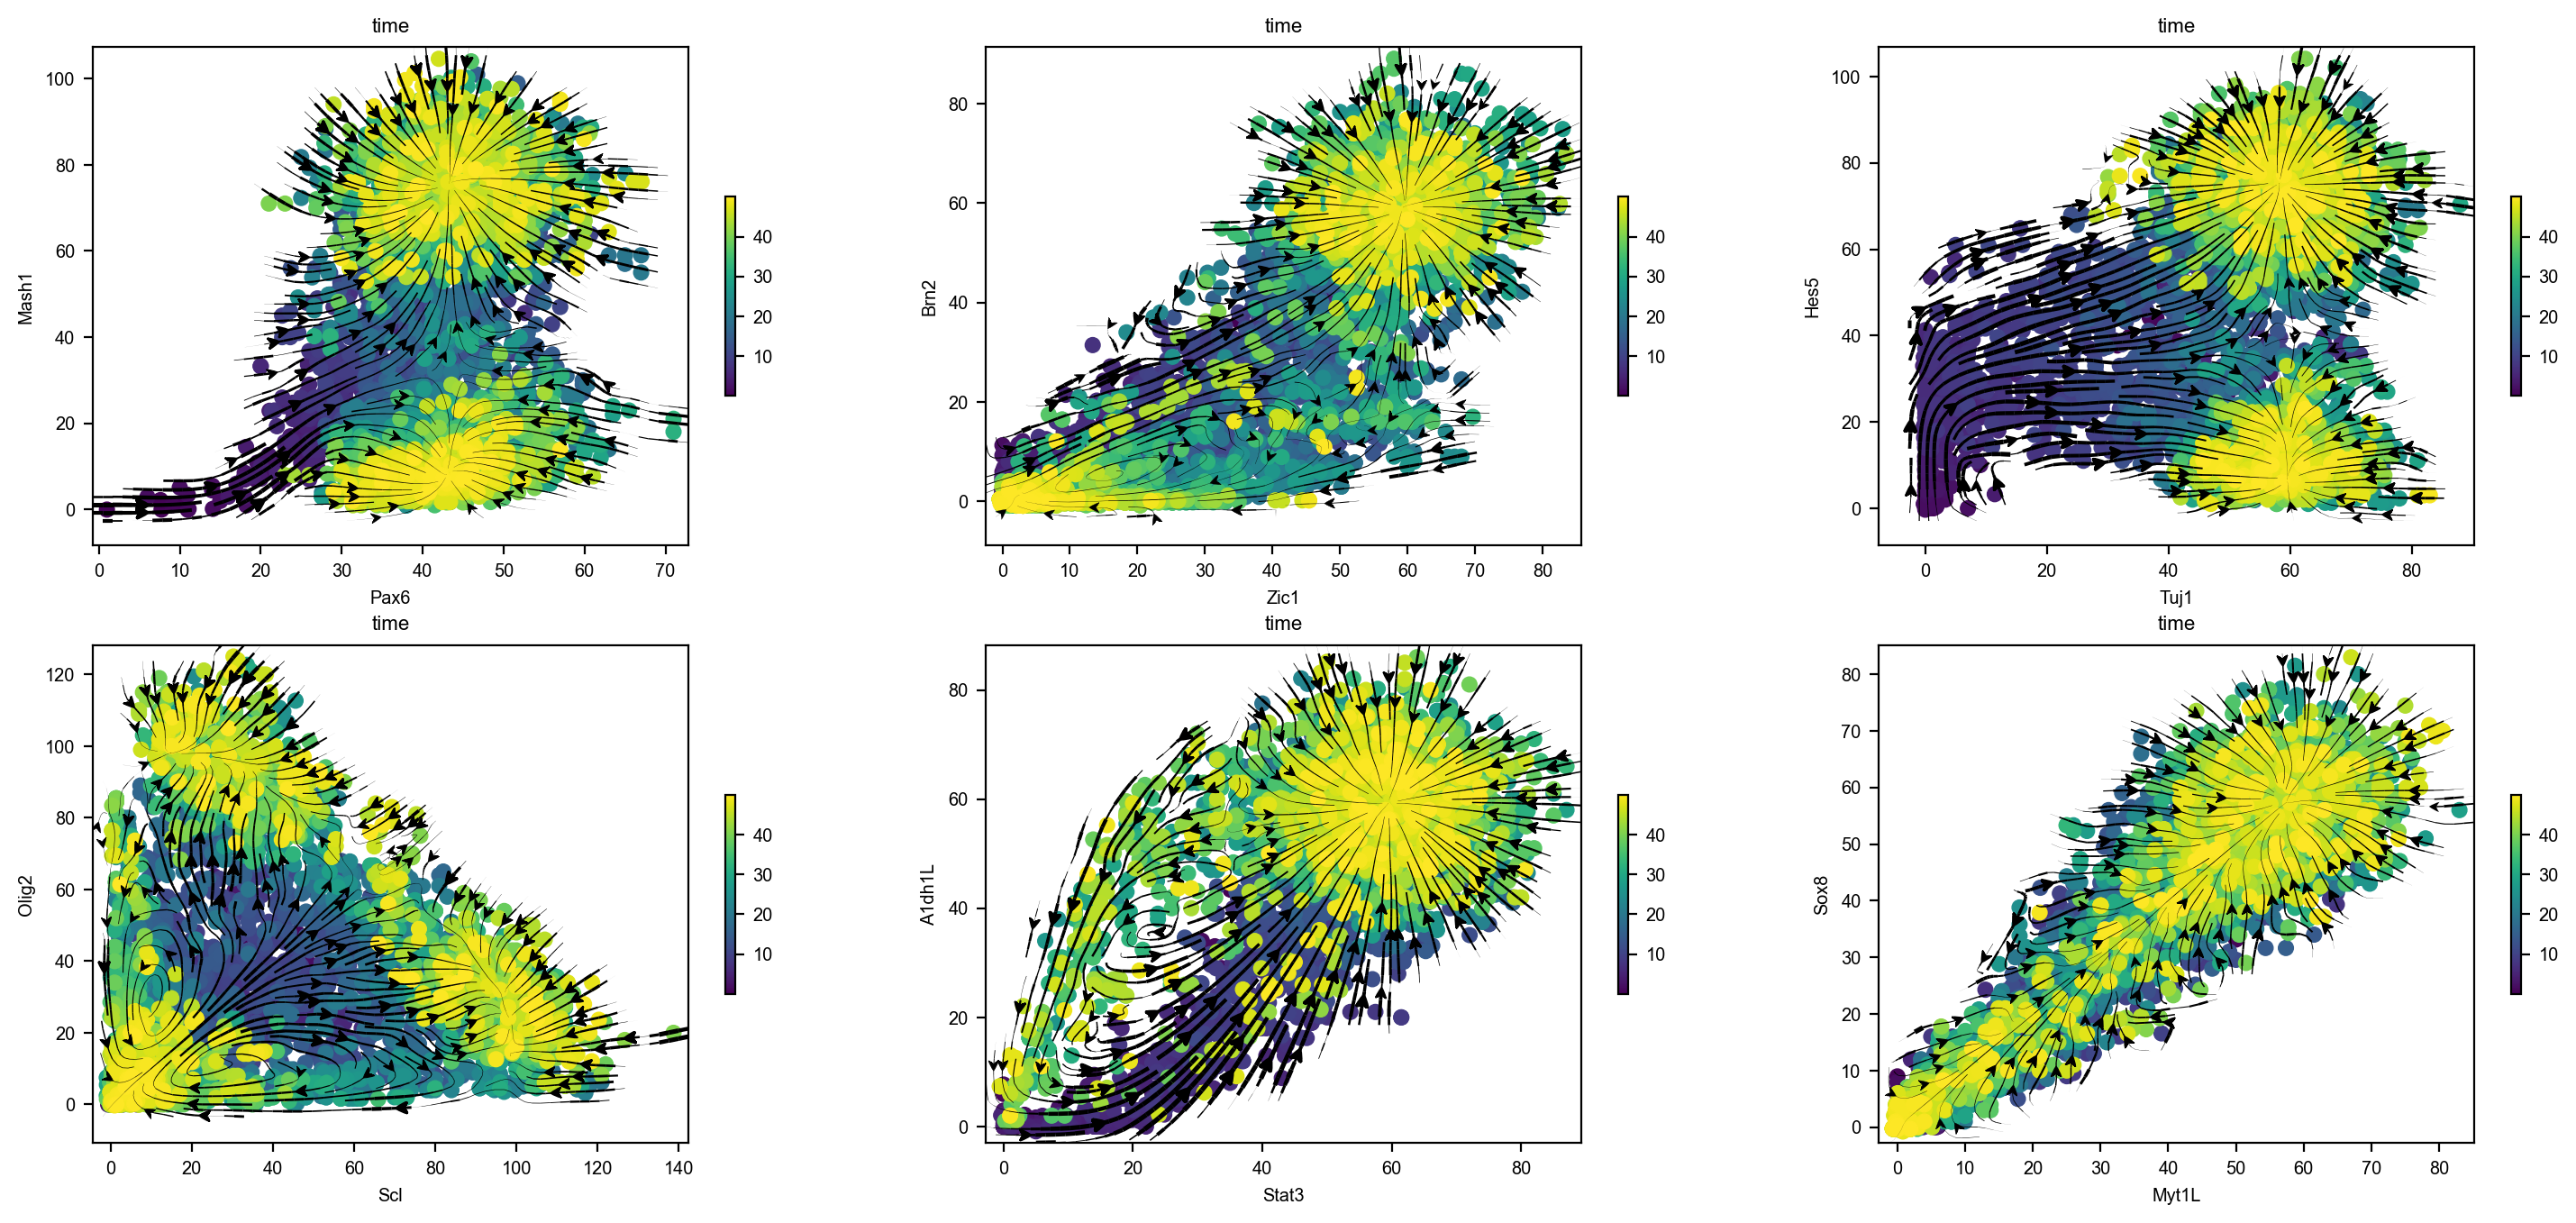

In [8]:
dyn.pl.multiplot(lambda x, y: 
                 [dyn.pl.zscatter(adata, basis='raw', color='time', dims=[x, y], cmap='viridis'), 
                  dyn.pl.zstreamline(adata, basis='raw', dims=[x, y]),
                  plt.axis('on'),
                  plt.xlabel(simulator.gene_names[x]),
                  plt.ylabel(simulator.gene_names[y]),
                 ],
                 [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]])

In [9]:
def two_gene_plot(gene_x, gene_y, color='time', axis_off=False):
    x = simulator.species['total', gene_x]
    y = simulator.species['total', gene_y]
    dyn.pl.zscatter(adata, basis='raw', color=color, dims=[x, y], cmap='viridis'),
    dyn.pl.zstreamline(adata, basis='raw', dims=[x, y]),
    plt.xlabel(gene_x)
    plt.ylabel(gene_y)
    if axis_off:
        plt.axis('off')
    else:
        plt.axis('on')

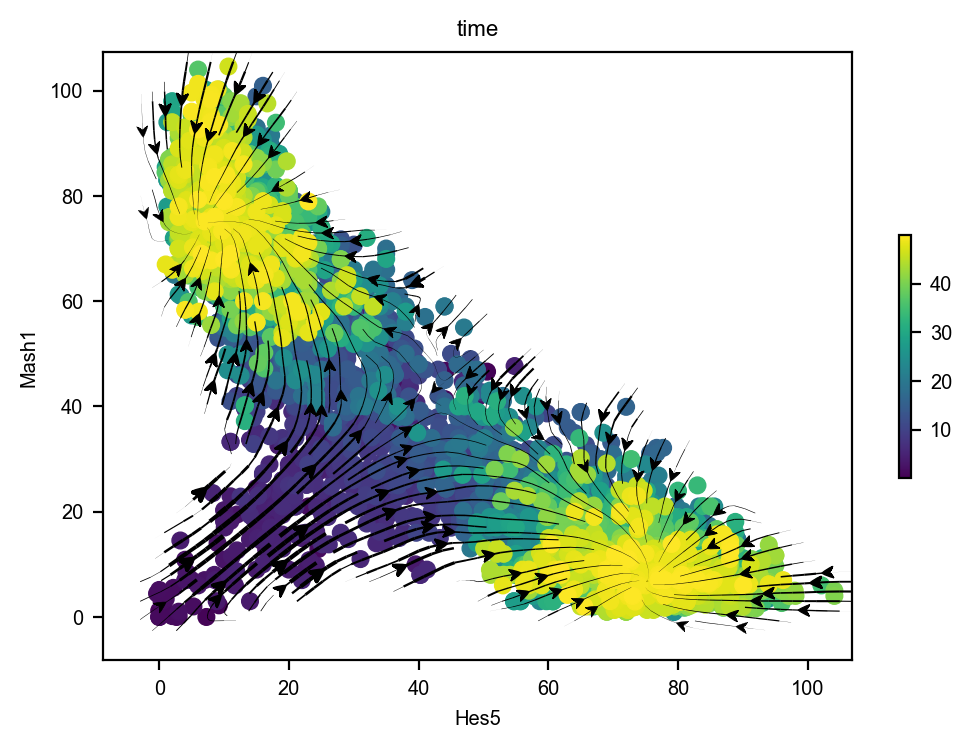

In [10]:
two_gene_plot('Hes5', 'Mash1')

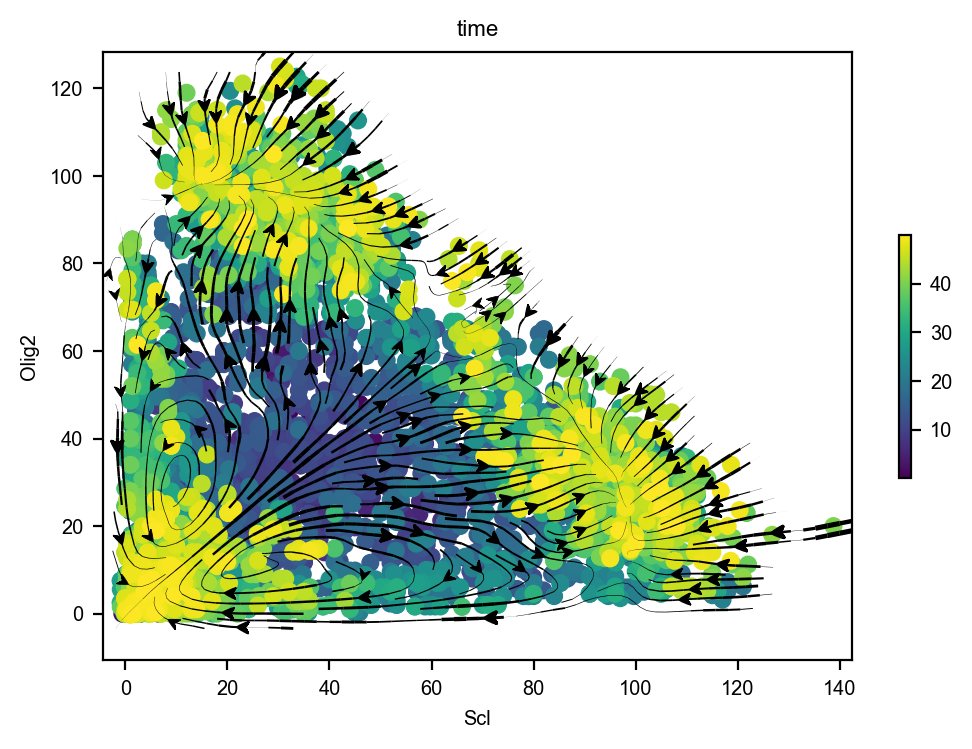

In [11]:
two_gene_plot('Scl', 'Olig2')

In [12]:
vf = dyn.vf.BaseVectorField(X=adata.layers['total'], V=adata.layers['velocity_T'])
vf.func = simulator.vfunc
vf.find_fixed_points()

In [13]:
stable_fixed_points = []
Xss, ftype = vf.get_fixed_points()
for i, xss in enumerate(Xss):
    if ftype[i] == -1:
        stable_fixed_points.append(xss)
stable_fixed_points = np.array(stable_fixed_points)

In [14]:
xss_dict = {
    'neuron': stable_fixed_points[np.argmax(stable_fixed_points[:, simulator.species['total', 'Mash1']])],
    'astrocyte': stable_fixed_points[np.argmax(stable_fixed_points[:, simulator.species['total', 'Scl']])],
    'oligodendr': stable_fixed_points[np.argmax(stable_fixed_points[:, simulator.species['total', 'Olig2']])]
}

In [15]:
def find_cells_in_sphere(X, center, radius):
    cells = []
    for i, x in enumerate(X):
        if np.linalg.norm(x - center) <= radius:
            cells.append(i)
    return np.array(cells)

In [16]:
cell_type = np.array(['progenitor' for i in range(adata.n_obs)])

for ctype, xss in xss_dict.items():
    #cells = nearest_neighbors(xss, adata.layers['total'], k=300)[0]
    cells = find_cells_in_sphere(adata.layers['total'], xss, 30)
    cell_type[cells] = ctype
    
adata.obs['cell_type'] = cell_type

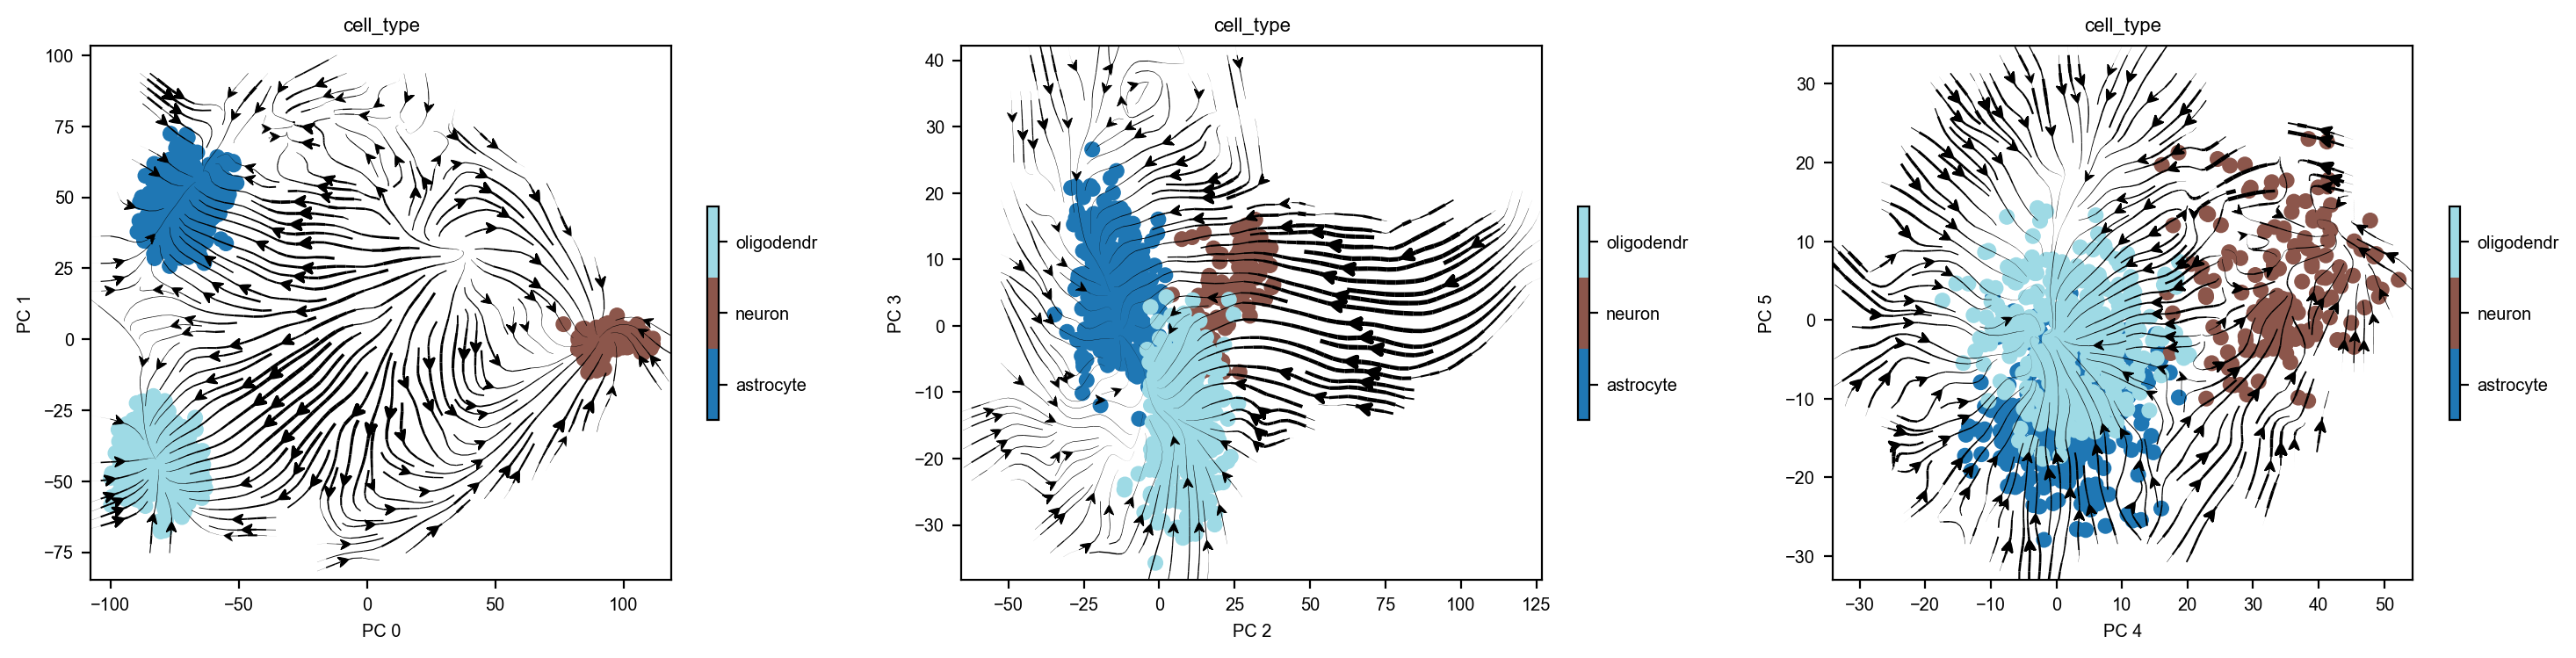

In [17]:
cells = dyn.tl.select_cell(adata, 'cell_type', list(xss_dict.keys()))
dyn.pl.multiplot(lambda x, y: 
                 [dyn.pl.zscatter(adata[cells], basis='pca', color='cell_type', dims=[x, y]), 
                  dyn.pl.zstreamline(adata, basis='pca', dims=[x, y]),
                  plt.axis('on'),
                  plt.xlabel(f'PC {x}'),
                  plt.ylabel(f'PC {y}'),
                 ],
                 [[0, 1], [2, 3], [4, 5]])

plt.savefig('neurogenesis_fixed_points.pdf')

In [18]:
adata.write(f"../data/simulation/neurogenesis_tau{tau}_rep10.h5ad")